In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pyransac3d as pyrsc
import numpy as np
import random
import math

In [2]:
def plane_fit(pts, ignore_points=[], filtered_points=[], thresh=0.05, minPoints=100, maxIteration=1000):
    
    """
    pyransac3d PyPI
    Find the best equation for a plane.

    :param pts: 3D point cloud as a `np.array (N,3)`.
    :param ignore_points: which index need to ignore at the time of sampling
    :param filtered_points: which index needs to be filtered
    :param thresh: Threshold distance from the plane which is considered inlier.
    :param maxIteration: Number of maximum iteration which RANSAC will loop over.
    :returns:
    - `equation`:  Parameters of the plane using Ax+By+Cy+D `np.array (1, 4)`
    - `inliers`: points from the dataset considered inliers

    ---
    """
    n_points = pts.shape[0]
    best_eq = []
    first_best_eq = []
    second_best_eq = []
    best_inliers = []
    first_best_inliers = []
    second_best_inliers = []
    
    if ignore_points:
        total_points = np.arange(0, n_points, 1)
        filtered_points = list(total_points)
        for i in ignore_points:
            filtered_points.remove(i)        
    

    for it in range(maxIteration):

        # Samples 3 random points
        # id_samples = random.sample(range(0, n_points), 3)
        id_samples = random.sample(filtered_points, 3)
        pt_samples = pts[id_samples]

        # We have to find the plane equation described by those 3 points
        # We find first 2 vectors that are part of this plane
        # A = pt2 - pt1
        # B = pt3 - pt1

        vecA = pt_samples[1, :] - pt_samples[0, :]
        vecB = pt_samples[2, :] - pt_samples[0, :]

        # Now we compute the cross product of vecA and vecB to get vecC which is normal to the plane
        vecC = np.cross(vecA, vecB)

        # The plane equation will be vecC[0]*x + vecC[1]*y + vecC[0]*z = -k
        # We have to use a point to find k
        vecC = vecC / np.linalg.norm(vecC)
        k = -np.sum(np.multiply(vecC, pt_samples[1, :]))
        plane_eq = [vecC[0], vecC[1], vecC[2], k]

        # Distance from a point to a plane
        # https://mathworld.wolfram.com/Point-PlaneDistance.html
        pt_id_inliers = []  # list of inliers ids
        dist_pt = (
            plane_eq[0] * pts[:, 0] + plane_eq[1] * pts[:, 1] + plane_eq[2] * pts[:, 2] + plane_eq[3]
        ) / np.sqrt(plane_eq[0] ** 2 + plane_eq[1] ** 2 + plane_eq[2] ** 2)

        # Select indexes where distance is biggers than the threshold
        pt_id_inliers = np.where(np.abs(dist_pt) <= thresh)[0]
        
#         for point in pt_id_inliers:
#             if point not in filtered_points:
#                 wh = np.where(pt_id_inliers==point)
#                 pt_id_inliers = np.delete(pt_id_inliers, wh)
        
        if len(pt_id_inliers) > len(best_inliers):
            best_eq = plane_eq
            best_inliers = pt_id_inliers
        inliers = best_inliers
        equation = best_eq
               
    return equation, inliers

In [3]:
file = scipy.io.loadmat('C:/Users/HP/Desktop/Jupyter_notebook files/Computer vision/Exercise 01/example3kinect.mat')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


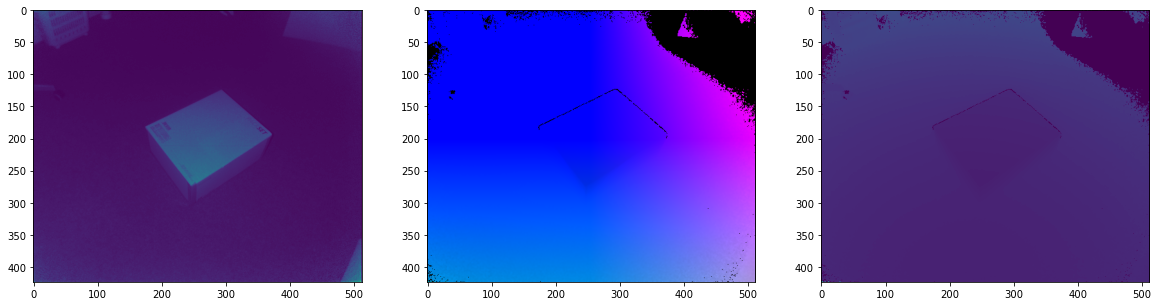

In [4]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(file['amplitudes3'])
plt.subplot(1, 3, 2)
plt.imshow(file['cloud3'])
plt.subplot(1, 3, 3)
plt.imshow(file['distances3'])
plt.show()

In [5]:
## Finding first inliers
## Floor

cloud = np.array(file['cloud3']) # Load your point cloud as a numpy array (N, 3)
height = cloud.shape[0]
width = cloud.shape[1]
points = cloud.reshape((height*width, 3))
points_list = list(points)
ignore_points = []

for i in range(0, height):
    for j in range(0, width):
        a = cloud[i][j][0]
        b = cloud[i][j][1]
        c = cloud[i][j][2]

        if (a==0 and b==0 and c==0):
            index = width*i + j
            ignore_points.append(index)
            
best_eq1, best_inliers1 = plane_fit(np.array(points_list), ignore_points = ignore_points, thresh=0.05, maxIteration=100)


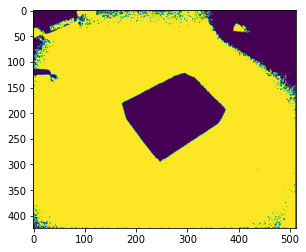

In [6]:
## Drawing floor from first inliers

floor_mask_image = np.zeros((height, width))

for point in best_inliers1:
    i = math.floor(point/width)
    j = point%width
    floor_mask_image[i][j] = 1

plt.imshow(floor_mask_image)
plt.show()

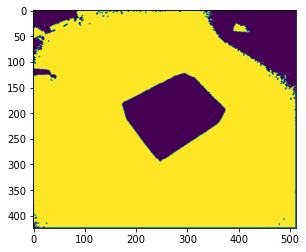

In [7]:
## Using morphological operator

import scipy.ndimage.morphology
filtered_floor_mask_image = scipy.ndimage.morphology.binary_closing(floor_mask_image).astype(np.int)
plt.imshow(filtered_floor_mask_image)
plt.show()

In [8]:
## Making the filtered floor masked image inverse

n_points = np.array(points_list).shape[0]
total_points = np.arange(0, n_points, 1)
filtered_points2 = []

for i in range(0, n_points):
    if i in best_inliers1:
        pass
    else:
        filtered_points2.append(i)

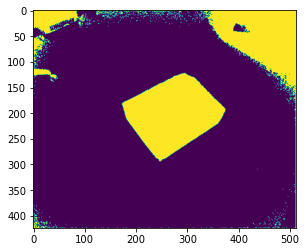

In [9]:
## Making the filtered floor masked image inverse

inverse_floor_mask = np.zeros((height, width))

for point in filtered_points2:
    i = math.floor(point/width)
    j = point%width
    inverse_floor_mask[i][j] = 1

plt.imshow(inverse_floor_mask)
plt.show()

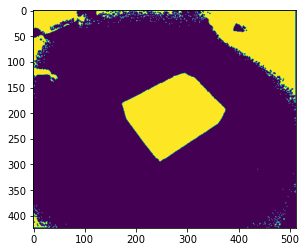

In [10]:
## Using morphological operator on inverse image

import scipy.ndimage.morphology
inversed_filtered_floor_mask_image = scipy.ndimage.morphology.binary_closing(inverse_floor_mask).astype(np.int)
plt.imshow(inversed_filtered_floor_mask_image)
plt.show()

In [11]:
## Find largest connected component

from scipy.ndimage import label
np.set_printoptions(threshold=np.inf)
labeled_array, num_features = label(inversed_filtered_floor_mask_image, structure=None)

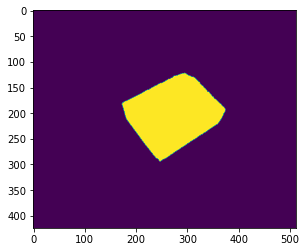

In [12]:
## Find largest connected component

from scipy import ndimage
sizes = ndimage.sum(inversed_filtered_floor_mask_image, labeled_array, range(num_features + 1))
mask = sizes > 20000 ## Hyperparameter
box_mask = mask[labeled_array]
plt.imshow(box_mask)
plt.show()

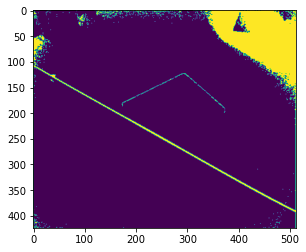

In [13]:
## Getting the index of the previous binary image

filtered_points2 = []
ignore_points2 = []

for i in range(0, height):
    for j in range(0, width):
        if (box_mask[i][j] == 1):
            index = width*i + j
            #ignore_points2.append(index)
            filtered_points2.append(index)

## Finding best inliers from the previous binary image
best_eq2, best_inliers2 = plane_fit(np.array(points_list), filtered_points = filtered_points2, thresh=0.005, maxIteration=100)
#best_eq2, best_inliers2 = plane_fit(np.array(points_list), ignore_points=ignore_points2, thresh=0.007, maxIteration=50)
## Detection of box top
boxtop_mask_image = np.zeros((height, width))

for point in best_inliers2:
    #if point in filtered_points2:
    i = math.floor(point/width)
    j = point%width
    boxtop_mask_image[i][j] = 1

plt.imshow(boxtop_mask_image)
plt.show()

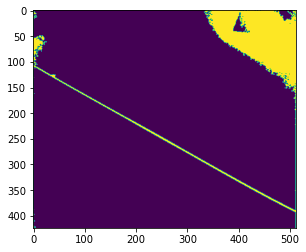

In [14]:
## Again find the largest connected component

from scipy.ndimage import label
np.set_printoptions(threshold=np.inf)
labeled_array, num_features = label(boxtop_mask_image, structure=None)

from scipy import ndimage
sizes = ndimage.sum(boxtop_mask_image, labeled_array, range(num_features + 1))
mask = sizes > 16000
boxtop_mask = mask[labeled_array].astype(np.int)
plt.imshow(boxtop_mask)
plt.show()

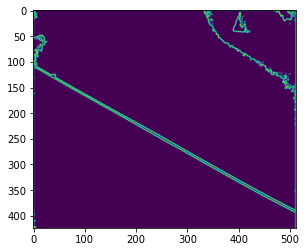

In [15]:
## Finding corners

from scipy import ndimage

sx = ndimage.sobel(boxtop_mask, axis=0, mode='constant')
sy = ndimage.sobel(boxtop_mask, axis=1, mode='constant')
boxtop_edge = np.hypot(sx, sy)

plt.imshow(boxtop_edge)
plt.show()

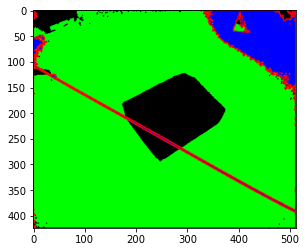

In [16]:
floor = filtered_floor_mask_image
box_top = boxtop_mask
box_top_edge = boxtop_edge
new_image = np.zeros((height, width, 3))

for i in range(0,height):
    for j in range(0,width):
        if box_top_edge[i][j] != 0:
            new_image[i][j][0] = 1
        elif box_top[i][j] == 1:
            new_image[i][j][2] = 1
        elif floor[i][j] == 1:
            new_image[i][j][1] = 1
            
plt.imshow(new_image)
plt.show()


In [17]:
## Calculating area
## Collect boxtop points
points = []
for i in range(0, height):
    for j in range(0, width):
        if (box_top[i][j] == 1):
            points.append((i,j))
            
## finding x, y from boxtop points
max_x = -1
min_x = width - 1
max_y = -1
min_y = height - 1
for pt in points:
    x = pt[1]
    y = pt[0]
    if x > max_x:
        max_x = x
    if x < min_x:
        min_x = x
    if y > max_y:
        max_y = y
    if y < min_y:
        min_y = y
        
print(max_x, min_x)
print(max_y, min_y)

511 0
423 0


In [18]:
## Calculating area
area = (max_x - min_x)* (max_y - min_y)
area

216153

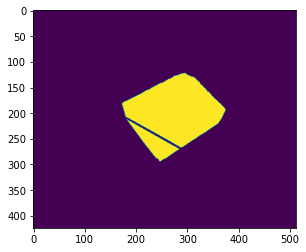

In [19]:
## Height
## box_mask - box_top

img1 = box_mask.astype(int)
img2 = box_top.astype(int)

for i in range(0,height):
    for j in range(0,width):
        if img2[i][j] == 1:
            img1[i][j] = 0
            
plt.imshow(img1)
plt.show()

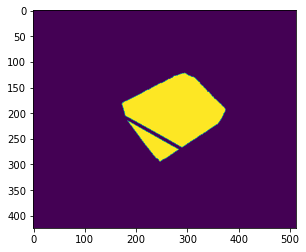

In [20]:
## Height
## img1 - box_top_edge

for i in range(0,height):
    for j in range(0,width):
        if box_top_edge[i][j] != 0:
            img1[i][j] = 0
plt.imshow(img1)
plt.show()

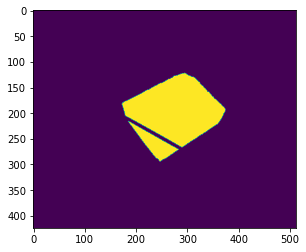

In [21]:
## Height
## Again find the largest connected component

from scipy.ndimage import label
np.set_printoptions(threshold=np.inf)
labeled_array, num_features = label(img1, structure=None)

from scipy import ndimage
sizes = ndimage.sum(img1, labeled_array, range(num_features + 1))
mask = sizes > 1000
binary_img = mask[labeled_array].astype(np.int)
plt.imshow(binary_img)
plt.show()

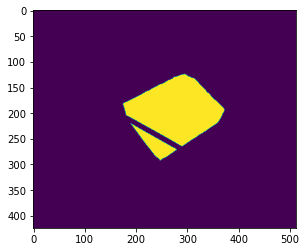

In [22]:
## Height
## Using binary_erosion operator on inverse image

import scipy.ndimage.morphology
filtered_side_mask = scipy.ndimage.morphology.binary_erosion(binary_img).astype(np.int)
filtered_side_mask1 = scipy.ndimage.morphology.binary_erosion(filtered_side_mask).astype(np.int)
plt.imshow(filtered_side_mask1)
plt.show()

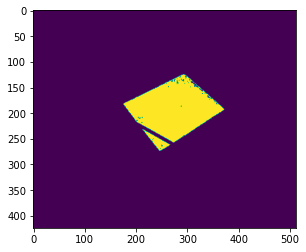

In [23]:
## Height
## Find box side mask from best inliers

filtered_points3 = []
ignore_points3 = []
for i in range(0, height):
    for j in range(0, width):
        if (binary_img[i][j] == 1):
            index = width*i + j
            #ignore_points2.append(index)
            filtered_points3.append(index)
            
best_eq3, best_inliers3 = plane_fit(np.array(points_list), filtered_points = filtered_points3, thresh=0.005, maxIteration=10)

## Detection of box top
box_side_mask = np.zeros((height, width))

for point in best_inliers3:
    if point in filtered_points3:
        i = math.floor(point/width)
        j = point%width
        box_side_mask[i][j] = 1

plt.imshow(box_side_mask)
plt.show()

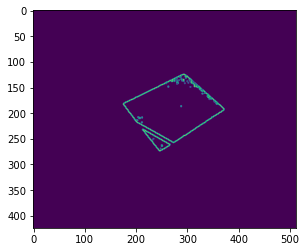

In [24]:
## Height
## Finding edge of box side mask
sx = ndimage.sobel(box_side_mask, axis=0, mode='constant')
sy = ndimage.sobel(box_side_mask, axis=1, mode='constant')
box_side_edge = np.hypot(sx, sy)
box_side_edge = np.array(box_side_edge.tolist())
plt.imshow(box_side_edge)
plt.show()

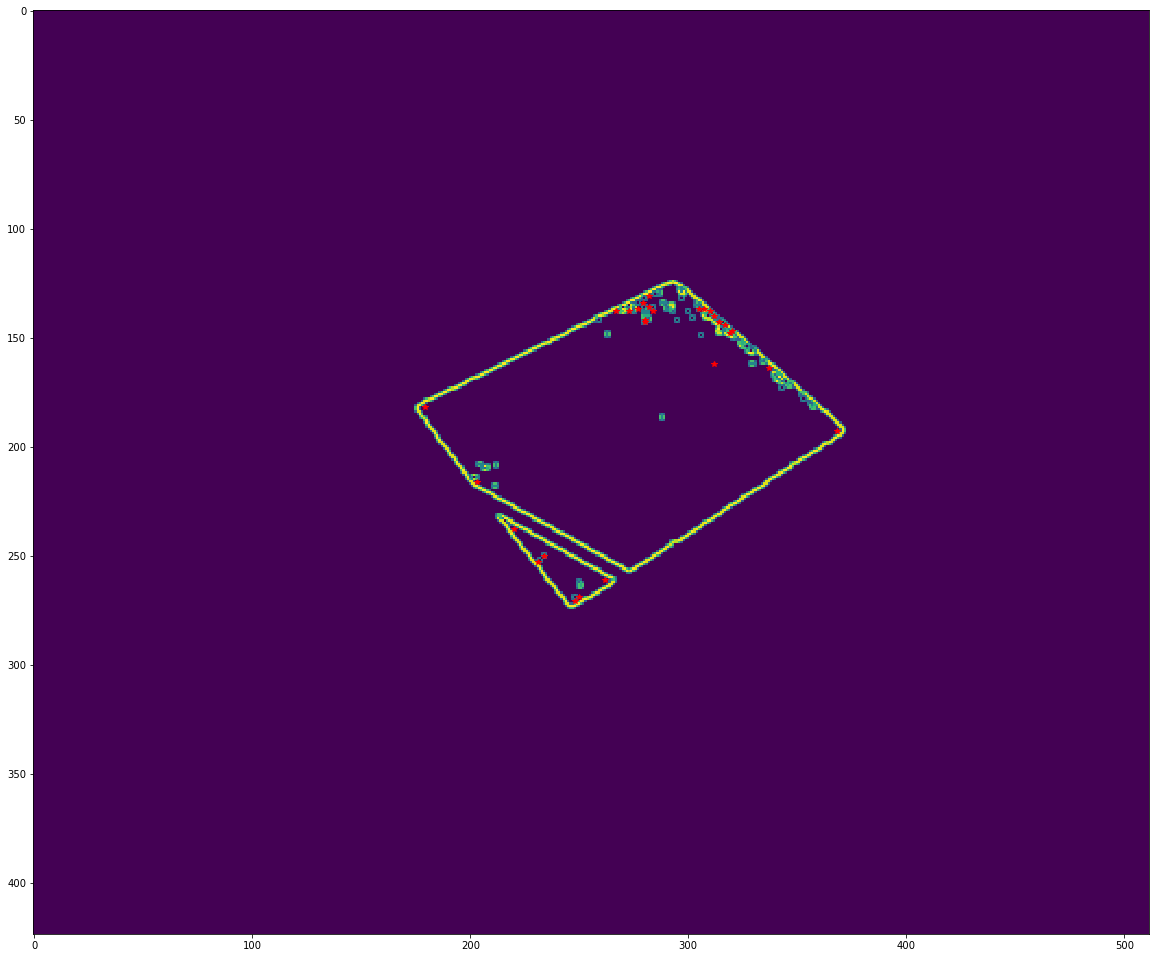

In [25]:
from skimage import io, color, morphology
from scipy.signal import convolve2d
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# Reduce all lines to one pixel thickness
snakes = morphology.skeletonize(box_side_edge < 1)

# Find pixels with only one neighbor
corners = convolve2d(snakes, [[1, 1, 1],
                              [1, 0, 1],
                              [1, 1, 1]], mode='same') == 1
corners = corners & snakes

# Those are the start and end positions of the segments
y, x = np.where(corners)

plt.figure(figsize = (20,20))
plt.imshow(box_side_edge,  interpolation='nearest')
plt.plot(x, y, 'r*')
# for i, j in zip(x, y):
#    plt.text(i, j+0.5, '({}, {})'.format(i, j))
# plt.scatter(x, y)
# plt.axis('on')
# plt.show()


In [26]:
## Calculate distances
# collecting points
point = []
for i in range(0, len(x)):
    point.append((x[i], y[i]))
    
# distance
distance = []
for i in point:
    d_each = []
    for j in point:
        if i != j:
            d = math.sqrt((i[0]-j[0])**2 + (i[1]-j[1])**2)
            d_each.append(d)
    distance.append(d_each)   
(distance)

[[4.242640687119285,
  5.0,
  7.810249675906654,
  23.769728648009426,
  25.709920264364882,
  16.55294535724685,
  11.40175425099138,
  7.280109889280518,
  28.861739379323623,
  31.32091952673165,
  11.180339887498949,
  12.165525060596439,
  34.17601498127012,
  37.33630940518894,
  41.23105625617661,
  40.718546143004666,
  43.139309220245984,
  64.1404708432983,
  114.93476410555685,
  106.01886624558857,
  116.04309544302927,
  123.664869708418,
  128.3160161476345,
  132.23085872821065,
  131.52946437965906,
  141.66156853571826,
  144.06942770761603],
 [4.242640687119285,
  3.605551275463989,
  3.605551275463989,
  26.1725046566048,
  28.160255680657446,
  12.649110640673518,
  7.211102550927978,
  6.4031242374328485,
  31.25699921617557,
  33.54101966249684,
  8.06225774829855,
  9.055385138137417,
  36.138621999185304,
  39.293765408777,
  43.01162633521314,
  42.37924020083418,
  43.278170016764804,
  65.29931086925804,
  110.92339699089638,
  106.78014796768171,
  111.80339

In [27]:
final = []
for p in distance:
    min_dist = min(p)
    if min_dist>5:
        final.append(min_dist)

h = sum(final)/len(final)
h

23.803194076893803

In [28]:
import cv2
from PIL import Image
side_edge_corner = box_side_edge
#vis0 = Image.fromarray(box_side_edge)
#img_gray = cv2.cvtColor(box_side_edge, cv2.COLOR_BGR2GRAY)
gray = np.float32(box_side_edge)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
side_edge_corner[dst!=0*dst.max()]=[0]

# cv2.imshow('dst',box_side_edge)
# if cv2.waitKey(0) & 0xff == 27:
#     cv2.destroyAllWindows()

In [29]:
## height
a = (best_eq1[0] +  best_eq2[0])/2
b = (best_eq1[1] +  best_eq2[1])/2
c = (best_eq1[2] +  best_eq2[2])/2
d1 = best_eq1[3]
d2 = best_eq2[3]

h = abs(d1-d2)/(math.sqrt(a**2 + b**2 + c**2))
h

1.9157480041042112